# Libraries and packages

Install packages

To start with the project we are going to install the the necessary libraries

In [ ]:
!pip install mlflow
!pip install requests
!pip install Levenshtein

Import libraries

To start with the project we are going to import the the necessary libraries for regular expression, request and json for api extraction, pandas, pylotm, numpy, grid search cv for finding the best hyperparameters for model, train test split, standart scaler for scalling the data, pipeline, mean_absolute_error, mean_squared_error and r2_score for scoring the prediction of the model, ada boost regressior for Train a weak learner on a random subset of the data, and import our models DecisionTreeRegressor, Ridge, Lasso and polynomial regression


In [2]:
import re

import requests
import json

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import jaccard_score
from scipy.spatial.distance import pdist, squareform

#Import models
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import mlflow

This cell will be used only when the file is executed through Colab or another similar Jupyter Notebook service.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

import os
path="/content/drive/My Drive/Colab Notebooks/"
os.chdir(path)
os.listdir(path)

# Start/Stop experiment

In this is used to stop or start experement in mlflow

In [ ]:
experiment_name = 'testing multiple models for regression with half of the users + more attriabutes '
mlflow.set_experiment(experiment_name)

In [37]:
mlflow.end_run()

In [39]:
mlflow.start_run()

<ActiveRun: >

# Idea

The idea of my project is to create a movie recommendation system. For it to work, the user needs to have a prior history or select movies they like. The system consists of several parts. The first part is content-based filtering using the 'Jaccard' metric. The second part involves creating a model that takes the characteristics of the movie and user ID as input data, with the output value being the user's rating for the given movie, rounded for model simplicity. The concept is that when the user enters a new favorite movie, similar movies will be retrieved using the 'Jaccard' metric, and the model will provide a probable rating for user liking.

For the creation of my project, I have decided to use resources from https://grouplens.org/datasets/movielens/20m/.
Firstly, let me provide you with information about the dataset. It consists of 20 million ratings given to 27,000 movies by 138,000 users. The files I will be using from the dataset are ratings.csv (user ratings), movies.csv (movie information), and links.csv.

The file movies.cvs you are given has already been completed thrugh the sections: Movies, One-hot encode, Extract year from the title and Getting more features from tmdb, so you don't need to run them.

# Movies

Let's start with the content of movies.csv.

In [3]:
movies = pd.read_csv('movies.csv')
print(movies.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


As you can see in the file, we have movieId, which we will use to link to ratings.csv and links.csv, a title that is a combination of the movie title and the release year, and genres. The genres of a movie are concatenated with the '|' symbol, so we will use one-hot encoding.

# One-hot encode

To simplify our work, we will convert the 'genres' column from a string to an array by splitting the genres using the '|' symbol.

In [ ]:
movies['genres'] = movies['genres'].str.split('|')

First, we will extract all genres in array.

In [ ]:
all_genres =[]
for genres in movies['genres']:
    for genre in genres:
        if genre not in all_genres:
            all_genres.append(genre)

Second, we will create new columns for the genres.

In [ ]:
genres = pd.DataFrame(columns=all_genres)
movies = pd.concat([movies, genres], axis=1)

After that, we will iterate through all movies and mark with 1 where each movie has a specific genre.

In [ ]:
for i, row in movies.iterrows():
     for genre in row['genres']:
          if genre in all_genres:
               movies.at[i, genre] = 1
movies.fillna(0, inplace=True)

At the end, we will remove the 'genres' column as it is no longer needed.

In [ ]:
movies.drop('genres', axis=1, inplace=True)

# Extract year from the title

The next step is to extract the year from the title. For this purpose, we will use a regular expression.

In [ ]:
years= movies['title'].str.extract(r'\b(\d{4})\b')
years.rename(columns={0: "Year"}, inplace=True)
movies = pd.concat([movies, years], axis=1)

# Getting more features from tmdb

To enhance the data for each film, we will utilize the tmdb database.

For this purpose, we will first create a method called get_movie_details() that takes the movie ID and returns it's features - popularity, vote_average,vote_count, runtime, revenue, original_language

In [57]:
def get_movie_details(id):
  url = 'https://api.themoviedb.org/3/movie/'+id+'?api_key=283affd7bc4e82ee3200dc59e08220f3'
  r = requests.get(url)
  return r.json()

Before we proceed with that, we will use the 'links.csv' file because the movies in tmdb have different IDs.

In [ ]:
links = pd.read_csv('links.csv')
movies = pd.merge(movies,links, on='movieId')

Then, we will iterate through all the movies to add the additional features by creating an if statement to check if some movies do not exist in tmdb.

In [ ]:
for i in range(0, len(movies) ):
  info = get_movie_details(movies.at[i,'tmdbId'].astype('str'))
  if 'popularity' in  info:
    movies.at[i,'popularity'] = info['popularity']
    movies.at[i,'vote_average'] = info['vote_average']
    movies.at[i,'vote_count'] = info['vote_count']
    movies.at[i,'runtime'] = info['runtime']
    movies.at[i,'revenue'] = info['revenue']
    movies.at[i,'original_language'] = info['original_language']

Now we have 5 extra features.

The next step is to remove the movies that do not exist in tmdb.

In [ ]:
for i,row in movies.iterrows():
  if row.isna().any():
    movies.drop(i,inplace=True)

After we no longer need the IDs from the links, we can remove them.

In [ ]:
movies.drop(['imdbId','tmdbId'], axis = 1, inplace =True)

In the end, the 'movies' variable should look like this.

In [135]:
print(movies.head())

   movieId                               title  Year  Adventure  Animation  \
0        1                    Toy Story (1995)  1995          1          1   
1        2                      Jumanji (1995)  1995          1          0   
2        3             Grumpier Old Men (1995)  1995          0          0   
3        4            Waiting to Exhale (1995)  1995          0          0   
4        5  Father of the Bride Part II (1995)  1995          0          0   

   Children  Comedy  Fantasy  Romance  Drama  ...  Musical  Western  \
0         1       1        1        0      0  ...        0        0   
1         1       0        1        0      0  ...        0        0   
2         0       1        0        1      0  ...        0        0   
3         0       1        0        1      1  ...        0        0   
4         0       1        0        0      0  ...        0        0   

   Film-Noir  (no genres listed)  popularity  vote_average  vote_count  \
0          0                  

After that, we round the popularity and vote_average to 0.5.

In [7]:
movies['popularity']= np.round(movies['popularity']*2)/2
movies['vote_average']= np.round(movies['vote_average']*2)/2

One more thing I want to do is add a column for language, where 1 indicates that the movie is in English, and 0 indicates that it's in another language.

In [ ]:
for i in range(0, len(movies) ):
    movies.at[i,'language'] = movies.at[i,'original_language'] == 'en'
movies.drop('original_language', axis=1, inplace=True)

Finally, we save the 'movies' variable to avoid repeated extractions through the API.

In [84]:
movies.to_csv('movies.csv', index=False)

# Ratings

The other file that will be necessary for us is 'ratings.csv'.

In [4]:
ratings = pd.read_csv('ratings.csv')
print(ratings.head())

   userId  movieId  raw_ratings   timestamp
0       1        2          3.5  1112486027
1       1       29          3.5  1112484676
2       1       32          3.5  1112484819
3       1       47          3.5  1112484727
4       1       50          3.5  1112484580


As you can see, the 'ratings.csv' file consists of userId, movieId, and timestamp.

Next, we will remove the 'timestamp' column from the ratings since it is not needed.

In [5]:
ratings.drop('timestamp', axis=1, inplace=True)

Finally, we round the ratings to facilitate the model.

In [92]:
ratings['raw_ratings'].apply(np.ceil)

0          4.0
1          4.0
2          4.0
3          4.0
4          4.0
          ... 
1048570    5.0
1048571    4.0
1048572    5.0
1048573    4.0
1048574    4.0
Name: raw_ratings, Length: 1048575, dtype: float64

# Content recommendation system

The next part of the project is to build a recommendation system based on the features of the movies.

For these purpose i have decided to use this metric 'jacard'. First of all let me explain how it operates. The metric works by taking two movies and afterwards it returns a value. These said value can be between 0 and 1, where 1 means that the films completly diffrent and 0 meaning that they are same. The value is being calculated by taking the amount of simularities and deviding that number by odd the elements in the metric

In [122]:
recommended_movies = movies.drop(['title', 'movieId', 'popularity', 'vote_average','vote_count','revenue'], axis=1)
recommended_movies.iloc[:,0:] = recommended_movies.iloc[:,0:].astype('float')

jaccard_distances = pdist(recommended_movies.values, metric='jaccard')

Then, we convert the differences into similarities and create a matrix.

In [123]:
jaccard_similarity_array = 1 - squareform(jaccard_distances)
jaccard_similarity_df = pd.DataFrame(jaccard_similarity_array, index=recommended_movies.index, columns=recommended_movies.index)

This is how our dataframe should look like.

In [124]:
print(jaccard_similarity_df.head())

      0         1         2         3         4         5         6      \
0  1.000000  0.625000  0.333333  0.300000  0.375000  0.181818  0.333333   
1  0.625000  1.000000  0.250000  0.222222  0.285714  0.222222  0.250000   
2  0.333333  0.250000  1.000000  0.666667  0.600000  0.250000  0.800000   
3  0.300000  0.222222  0.666667  1.000000  0.500000  0.222222  0.833333   
4  0.375000  0.285714  0.600000  0.500000  1.000000  0.285714  0.600000   

      7         8         9      ...     26731     26732     26733     26734  \
0  0.500000  0.222222  0.300000  ...  0.111111  0.250000  0.750000  0.125000   
1  0.666667  0.285714  0.375000  ...  0.000000  0.000000  0.500000  0.000000   
2  0.285714  0.333333  0.250000  ...  0.400000  0.166667  0.222222  0.200000   
3  0.250000  0.285714  0.222222  ...  0.333333  0.142857  0.200000  0.166667   
4  0.333333  0.400000  0.285714  ...  0.200000  0.200000  0.250000  0.250000   

      26735     26736     26737     26738  26739     26740  
0  0.11

# Prepare data for the model

First, we need to create the data that we will use for the model.

In [25]:
data = pd.merge(ratings, movies, on='movieId')
data.drop('title', axis=1, inplace=True)

This is how the data should look like.

In [26]:
print(data.head())

   userId  movieId  raw_ratings  Year  Adventure  Animation  Children  Comedy  \
0       1        2          3.5  1995          1          0         1       0   
1       5        2          3.0  1995          1          0         1       0   
2      13        2          3.0  1995          1          0         1       0   
3      29        2          3.0  1995          1          0         1       0   
4      34        2          3.0  1995          1          0         1       0   

   Fantasy  Romance  ...  Musical  Western  Film-Noir  (no genres listed)  \
0        1        0  ...        0        0          0                   0   
1        1        0  ...        0        0          0                   0   
2        1        0  ...        0        0          0                   0   
3        1        0  ...        0        0          0                   0   
4        1        0  ...        0        0          0                   0   

   popularity  vote_average  vote_count  runtime  

We will reduce the number of users for testing the model because testing on all data would take time.

In [51]:
users =data[(data['userId'] >=1) & (data['userId']<=80000)]
x = users
y = users.raw_ratings.astype('float')
x.drop('raw_ratings', axis=1, inplace=True)
x.drop('movieId', axis=1, inplace=True)

Then, we will split the data into two parts - training data and testing data.

In [127]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.01,shuffle=True)
standard_scaler = StandardScaler()
standart_scaler_train_x, standart_scaler_test_x, standart_scaler_train_y, standart_scaler_test_y = train_test_split(standard_scaler.fit_transform(x), y, test_size=0.01,shuffle=True)
polynomial_scaler = PolynomialFeatures()
polynomial_scaler_train_x, polynomial_scaler_test_x, polynomial_scaler_train_y, polynomial_scaler_test_y = train_test_split(polynomial_scaler.fit_transform(x), y, test_size=0.01,shuffle=True)

# Models

Now, we will explore all models and choose the best one along with their hyperparameters

The first model we will try is Decision Trees with and without scaled data. The chosen hyperparameters include:

max_depth - maximum depth

min_samples_split - specifies the minimum number of samples required to split an internal node. In other words, if a node in the tree contains fewer samples than min_samples_split, the algorithm will not attempt to split that node any further. This can help to prevent overfitting by ensuring that the model does not learn to perfectly predict the training data, at the expense of its ability to generalize to new data.

In [137]:
parameters= {
    'max_depth': [10,11,12,13,14,15,None],
    'min_samples_split': [100,200,300,400,500,600,700,800,900,1000],
}
cv = GridSearchCV(DecisionTreeRegressor(), parameters,cv=3,n_jobs=7)
cv.fit(train_x, train_y)

print(cv.best_params_)


mae = mean_absolute_error(test_y, np.ceil(cv.predict(test_x)*2)/2)
rmse = mean_squared_error(test_y,np.ceil( cv.predict(test_x)*2)/2, squared=False)
r2 = r2_score(test_y, np.ceil(cv.predict(test_x)*2)/2)


mlflow.log_param("best_params-Decision trees-19-without scaled data", cv.best_params_)
mlflow.log_metric("MAE-Decision trees-19-without scaled data", mae)
mlflow.log_param("RMSE-Decision trees-19-without scaled data", rmse)
mlflow.log_param("R-squared-Decision trees-19-without scaled data", r2)
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R-squared: {r2:.2f}')

{'max_depth': 14, 'min_samples_split': 900}
MAE: 0.75
RMSE: 1.01
R-squared: 0.11


In [ ]:
pipeline = Pipeline( [('scaler', StandardScaler()),
        ('dtr', DecisionTreeRegressor())])

parameters= {
    'dtr__criterion': ['squared_error', 'friedman_mse', 'absolute_error', ],
    'dtr__max_depth': [1,5,10,20,30,40,50]
}
cv = GridSearchCV(pipeline, parameters, scoring= 'neg_root_mean_squared_error',cv=3,n_jobs=7)
cv.fit(train_x, train_y)

print(cv.best_params_)


mae = mean_absolute_error(test_y, cv.predict(standart_scaler_test_x))
rmse = mean_squared_error(test_y, cv.predict(standart_scaler_test_x), squared=False)
r2 = r2_score(test_y, cv.predict(standart_scaler_test_x))


mlflow.log_param("best_params-Decision trees-7-with scaled data", cv.best_params_)
mlflow.log_metric("MAE-Decision trees-7-with scaled data", mae)
mlflow.log_param("RMSE-Decision trees-7-with scaled data", rmse)
mlflow.log_param("R-squared-Decision trees-7-with scaled data", r2)
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R-squared: {r2:.2f}')

{'dtr__criterion': 'friedman_mse', 'dtr__max_depth': 10}
MAE: 0.76
RMSE: 0.98
R-squared: 0.19


Second i would test linearSVR(), which requires scaled data. This is the only model I trained with less data because it takes more than 24 hours to compute.  For hyper parameters I have chosen:

C - this is the parameter for regularization - the higher the value, the bigger the regularization
Еpsilon - this is the sensitivity parameter to deviations - the larger it's value, the less sensitive the model will be
Loss - this parameter determines the loss function - 'squared_epsilon_insensitive', a modified version where errors smaller than epsilon are ignored, but errors larger than epsilon are raised to the power of 2 (squared) and 'epsilon_insensitive', where errors are smaller than a specified value of epsilon are ignored

In [ ]:
pipeline = Pipeline( [('scaler', StandardScaler()),
        ('svr', LinearSVR())])

parameters= {
    'svr__C': [0.1,0.3,0.5,0.7,0.9, 1],
    'svr__epsilon': [0.1, 0.2, 0.3, 0.4, 0.5],
    'svr__loss':['squared_epsilon_insensitive','epsilon_insensitive']
}

cv = GridSearchCV( pipeline, parameters, scoring= 'neg_root_mean_squared_error',cv=3,n_jobs=8)
cv.fit(train_x, train_y)

svr_mae = mean_absolute_error(test_y, cv.predict(standart_scaler_test_x))
svr_rmse = mean_squared_error(test_y, cv.predict(standart_scaler_test_x), squared=False)
svr_r2 = r2_score(test_y, cv.predict(standart_scaler_test_x))

print(cv.best_params_)

mlflow.log_param("best_params - Linear SVR-6", cv.best_params_)
mlflow.log_metric("MAE-Linear SVR-6", svr_mae)
mlflow.log_param("RMSE-Linear SVR-6", svr_rmse)
mlflow.log_param("R-squared-Linear SVR-6", svr_r2)

print(f'MAE: {svr_mae:.2f}')
print(f'RMSE: {svr_rmse:.2f}')
print(f'R-squared: {svr_r2:.2f}')

MAE: 0.78
RMSE: 0.99
R-squared: 0.17


In [ ]:
print(cv.best_params_)

{'svr__C': 0.1, 'svr__epsilon': 0.1, 'svr__loss': 'squared_epsilon_insensitive'}


Ridge

alpha - determines the regularization - the higher the value, the stronger the regularization.

In [79]:
pipeline = Pipeline( [('scaler', StandardScaler()),
        ('r', Ridge())])

parameters= {
    'r__solver': ['sag','saga'],
    'r__alpha':[0.1, 0.3, 0.5, 0.7, 0.9]
}

cv = GridSearchCV( pipeline, parameters, scoring= 'neg_root_mean_squared_error',cv=3,n_jobs=8)
cv.fit(standart_scaler_train_x, train_y)

ridge_mae = mean_absolute_error(test_y, cv.predict(standart_scaler_test_x))
ridge_rmse = mean_squared_error(test_y, cv.predict(standart_scaler_test_x), squared=False)
ridge_r2 = r2_score(test_y, cv.predict(standart_scaler_test_x))

print(cv.best_params_)

mlflow.log_param("best_params-ridge-6-with scalled data", cv.best_params_)
mlflow.log_metric("MAE-ridge-6-with scalled data", ridge_mae)
mlflow.log_param("RMSE-ridge-6-with scalled data", ridge_rmse)
mlflow.log_param("R-squared-ridge-6-with scalled data", ridge_r2)

print(f'MAE: {ridge_mae:.2f}')
print(f'RMSE: {ridge_rmse:.2f}')
print(f'R-squared: {ridge_r2:.2f}')

{'r__alpha': 0.9, 'r__solver': 'sag'}
MAE: 0.84
RMSE: 1.05
R-squared: -0.00


In [98]:
parameters= {
    'solver': ['sag','saga'],
    'alpha':[0.1, 0.3, 0.5, 0.7, 0.9]
}

cv = GridSearchCV( Ridge(), parameters, scoring= 'neg_root_mean_squared_error',cv=3,n_jobs=8)
cv.fit(train_x, train_y)

ridge_mae = mean_absolute_error(test_y, cv.predict(test_x))
ridge_rmse = mean_squared_error(test_y, cv.predict(test_x), squared=False)
ridge_r2 = r2_score(test_y, cv.predict(test_x))

print(cv.best_params_)

mlflow.log_param("best_params-ridge-5", cv.best_params_)
mlflow.log_metric("MAE-ridge-5", ridge_mae)
mlflow.log_param("RMSE-ridge-5", ridge_rmse)
mlflow.log_param("R-squared-ridge-5", ridge_r2)

print(f'MAE: {ridge_mae:.2f}')
print(f'RMSE: {ridge_rmse:.2f}')
print(f'R-squared: {ridge_r2:.2f}')

{'alpha': 0.3, 'solver': 'sag'}
MAE: 0.84
RMSE: 1.05
R-squared: 0.00


c:\Users\Stefan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Lasso with and without scaled data. The chosen hyperparameter is:

alpha - determines the regularization - the higher the value, the stronger the regularization

In [76]:
parameters_for_sage= {
    'alpha':[0.1,0.3,0.5,0.7,0.9]
}

cv = GridSearchCV( Lasso, parameters_for_sage,scoring='max_error',cv=3,n_jobs=8)
cv.fit(standart_scaler_train_x, train_y)

lasso_mae = mean_absolute_error(test_y, cv.predict(standart_scaler_test_x))
lasso_rmse = mean_squared_error(test_y, cv.predict(standart_scaler_test_x), squared=False)
lasso_r2 = r2_score(test_y, cv.predict(standart_scaler_test_x))

print(cv.best_params_)

mlflow.log_param("best_params-lasso-3-with scalled data", cv.best_params_)
mlflow.log_metric("MAE-lasso-3-with scalled data", lasso_mae)
mlflow.log_param("RMSE-lasso-3-with scalled data", lasso_rmse)
mlflow.log_param("R-squared-lasso-3-with scalled data", lasso_r2)

print(f'MAE: {lasso_mae:.2f}')
print(f'RMSE: {lasso_rmse:.2f}')
print(f'R-squared: {lasso_r2:.2f}')

{'l__alpha': 0.1}
MAE: 0.84
RMSE: 1.05
R-squared: -0.00


In [96]:
parameters_for_sage= {
    'alpha':[0.1,0.3,0.5,0.7,0.9]
}

cv = GridSearchCV( Lasso(), parameters_for_sage,scoring='max_error',cv=3,n_jobs=8)
cv.fit(train_x, train_y)

lasso_mae = mean_absolute_error(test_y, cv.predict(test_x))
lasso_rmse = mean_squared_error(test_y, cv.predict(test_x), squared=False)
lasso_r2 = r2_score(test_y, cv.predict(test_x))

print(cv.best_params_)

mlflow.log_param("best_params-lasso-3-without scalled data", cv.best_params_)
mlflow.log_metric("MAE-lasso-3-without scalled data", lasso_mae)
mlflow.log_param("RMSE-lasso-3-without scalled data", lasso_rmse)
mlflow.log_param("R-squared-lasso-3-without scalled data", lasso_r2)

print(f'MAE-1: {lasso_mae:.2f}')
print(f'RMSE-1: {lasso_rmse:.2f}')
print(f'R-squared-1: {lasso_r2:.2f}')

{'alpha': 0.9}
MAE-1: 0.81
RMSE-1: 1.02
R-squared-1: 0.06


Polynomial Regression

As the final model, I decided to use Polynomial Regression.

In [129]:
polynomial_model =LinearRegression()
polynomial_model.fit(polynomial_scaler_train_x, train_y)

polynomial_mae = mean_absolute_error(test_y, cv.predict(test_x))
polynomial_rmse = mean_squared_error(test_y, cv.predict(test_x), squared=False)
polynomial_r2 = r2_score(test_y, cv.predict(test_x))


mlflow.log_metric("MAE-polynomial-features-1", polynomial_mae)
mlflow.log_param("RMSE-polynomial-features-1", polynomial_rmse)
mlflow.log_param("R-squared-polynomial-features-1", polynomial_r2)

print(f'MAE-1: {polynomial_mae:.2f}')
print(f'RMSE-1: {polynomial_rmse:.2f}')
print(f'R-squared-1: {polynomial_r2:.2f}')

MAE-1: 0.75
RMSE-1: 0.96
R-squared-1: 0.19


# Conclusion

From the above results, it can be seen that DecisionTreeRegressor performs the best. However, both it and all the other models appear to be weak - MAE and RMSE have high values, and R^2 has a small value.

Now I will show you charts of the difference between the original and predicted values for the best models - DecisionTreeRegressor without scaled data, Ridge with scaled data, and Lasso without scaled data.

The first chart is for DecisionTreeRegressor. In this case, 62% of the prediction results have a deviation of +/- 0.5, while 84% have a deviation of +/- 1 from the 5-point rating.

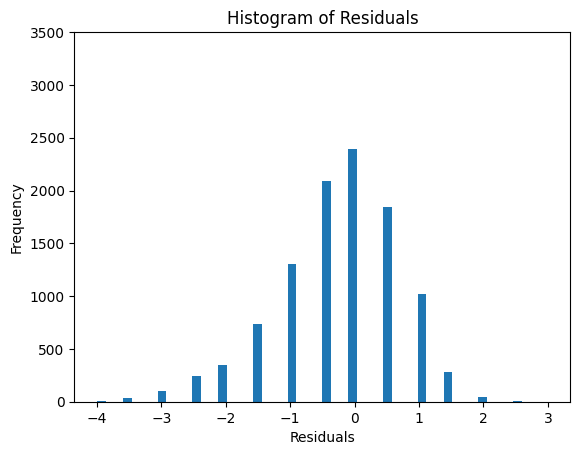

In [117]:
model = DecisionTreeRegressor(max_depth=14, min_samples_split=1000)
model.fit(train_x, train_y)


rounded_predictions = np.ceil(model.predict(test_x)*2)/2

errors = test_y - rounded_predictions

plt.hist(errors, bins= 'auto')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.ylim(0, 3500)
plt.show()



From the chart, we can see that the most significant factors are vote_average, user, and the popularity of the movie.

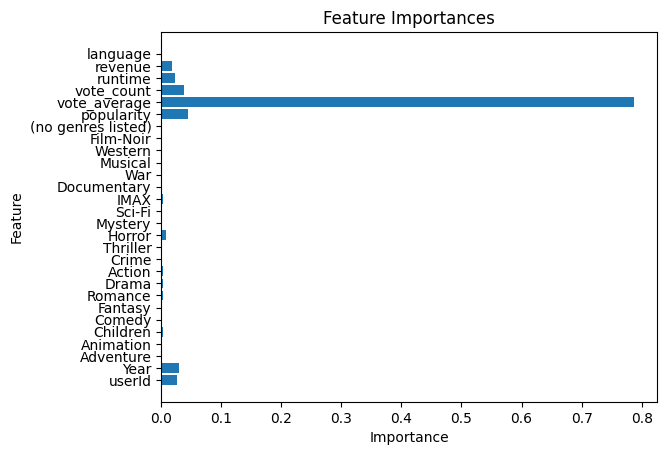

In [109]:
plt.barh(model.feature_names_in_,model.feature_importances_)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [110]:
ridge = Ridge(alpha=0.9, solver='sag')
ridge.fit(standart_scaler_train_x, train_y)

Ridge(alpha=0.9, solver='sag')

The second chart is for Ridge. In this case, 59.5% of the prediction results have a deviation of +/- 0.5, while 72% have a deviation of +/- 1 from the 5-point rating.

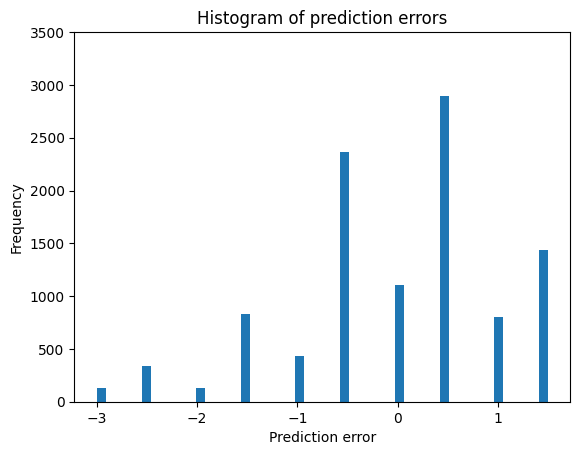

In [112]:
rounded_predictions = np.round(ridge.predict(standart_scaler_test_x)*2)/2
 
errors = test_y - rounded_predictions

plt.hist(errors, bins='auto' )
plt.title('Histogram of prediction errors')
plt.xlabel('Prediction error')
plt.ylabel('Frequency')
plt.ylim(0, 3500)
plt.show()

In [113]:
lasso = Lasso(alpha=0.1)
lasso.fit(train_x, train_y)

Lasso(alpha=0.1)

The third chart is for Lasso. In this case, 28% of the prediction results have a deviation of +/- 0.5, while 45% have a deviation of +/- 1 from the 5-point rating.

c:\Users\Stefan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


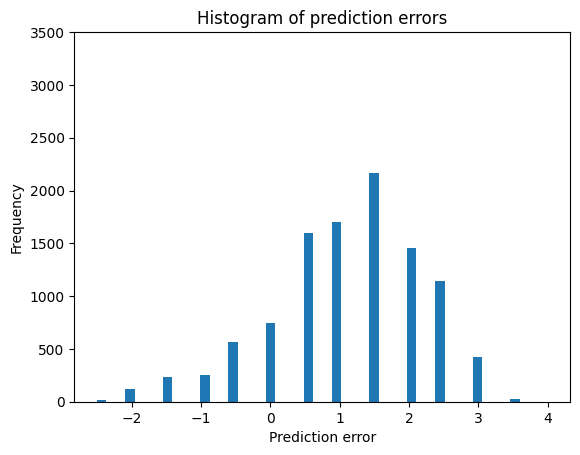

In [120]:
rounded_predictions = np.round(lasso.predict(standart_scaler_test_x)*2)/2
 
errors = test_y - rounded_predictions
plt.hist(errors, bins='auto')  
plt.title('Histogram of prediction errors')
plt.xlabel('Prediction error')
plt.ylabel('Frequency')
plt.ylim(0, 3500)
plt.show()

# Implementation

Finally, you can try my project.

First, we will create an algorithm to search for movies similar to the name if the user misspells the name of the liked movie.

In [143]:
import Levenshtein

def find_closest_movie(movie_name, movie_list):
        closest_movie = None
        min_distance = float('inf')
        
        for movie in movie_list:
            distance = Levenshtein.distance(movie_name, movie)
            if distance < min_distance:
                min_distance = distance
                closest_movie = movie
        
        return closest_movie

That's it! Now you need to enter your favorite movies and give him rating, then type "exit," enter a movie, and it will show you similar movies using the Jaccard metric along with their ratings from the model.

In [ ]:
user_id = 11111
movies_from_user = x[0:0]
ratings_from_user = y[0:0]

movie = input('Enter your favorite movie or enter exit to exit: ')

while movie != 'exit':
    closest_movie = find_closest_movie(movie, movies['title'])
    movie_index = np.where(movies['title'] == closest_movie)

    rating = input('Enter your rating for this movie: ')

    movies_from_user = pd.concat([movies_from_user, movies.iloc[movie_index[0]]], axis=0)
    ratings_from_user.at[len(ratings_from_user)] = rating

    print(ratings_from_user)
    movie = input('Enter your favorite movie or enter exit to exit: ')

movies_from_user.drop('title', axis=1, inplace=True)
movies_from_user.drop('movieId', axis=1, inplace=True)
movies_from_user['userId'] = user_id

new_x_data = pd.concat([x, movies_from_user], axis=0)
new_y_data = pd.concat([y, ratings_from_user], axis=0)

best_model = DecisionTreeRegressor(max_depth=14, min_samples_split=1000)
best_model.fit(new_x_data, new_y_data)

movie_index = np.where(movies['title'] == closest_movie)

movie = input('Enter movie to get similar movies with their rating: ')

similar_movies = jaccard_similarity_df[movie_index[0]]


for i in range(5):
    a = x[0:0]

    movie_df = movies.iloc[similar_movies.index[i]].to_frame().T

    a = pd.concat([a, movie_df], axis=0)

    a.drop('title', axis=1, inplace=True)
    a.drop('movieId', axis=1, inplace=True)
    a['userId'] = user_id

    print(movies.at[similar_movies.index[i], 'title'] + '->:')
    print(best_model.predict(movies_from_user))


# Algorithms that can be used to implement recommendation systems

Other methods through which a similar recommendation system can be achieved include collaborative filtering - User-Based Collaborative Filtering or Item-Based Collaborative Filtering, and matrix factorization.

# Thanks to tmbd

Thank you tmdb for letting me using your api for collecting data
blue_square_1-5bdc75aaebeb75dc7ae79426ddd9be3b2be1e342510f8202baf6bffa71d7f5c4.svg